# CIFAR-10 이미지 생성하기

In [1]:
# 모듈 import

import os
import glob
import time
import cv2
from PIL import Image, ImageSequence

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
%matplotlib inline

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 6GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], 
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    except RuntimeError as e:
        print(e)

In [3]:
# 데이터 셋 구성
(train_x, _), (test_x, _) =  tf.keras.datasets.cifar10.load_data()
print(train_x.shape)

# pixel 값 확인
print("max pixel:", train_x.max()) # 255
print("min pixel:", train_x.min()) # 0

# 이미지를 -1, 1로 정규화
train_x = (train_x - 127.5) / 127.5

# 이미지를 0, 1로 정규화
#train_x = train_x / 255

# 최대 최소값 확인
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

# 이미지 타입 변환
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')

# 데이터 형태 확인
print(train_x.shape)

(50000, 32, 32, 3)
max pixel: 255
min pixel: 0
max pixel: 1.0
min pixel: -1.0
(50000, 32, 32, 3)


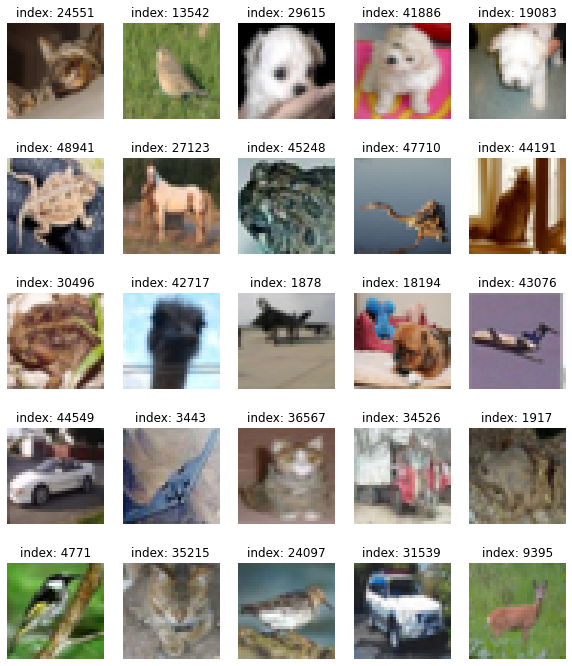

In [4]:
# 학습 데이터 확인
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index].reshape(32, 32, 3) + 1) / 2)
    #plt.imshow((train_x[random_index] + 1) / 2)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [5]:
# 학습 데이터 세트 설정
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## (1) 생성자-기본1 모델 (멍청한 생성자1: Comv2DTranspose() 함수를 사용한 생성자)
- Comv2DTranspose() + 'tanh'
- 가장 기본적인 성능만을 지닌 생성자와 판별자가 대결을 하면 과연 어떤 그림을 그릴 것인가?
- Comv2DTranspose() 함수를 사용하여 성능을 확인한다.

In [283]:
# 생성자-기본1 모델
# Comv2DTranspose() + 'tanh'
# 아무것도 추가 하지 않았다. 단지 Conv2DTranspose() 만 사용했을 뿐이
# 활성화 함수 X, 배치노말라이제이션 X, 드랍아웃 X, 추가적인 히든레이어 X 그 어떤 것도 없는 모델은 과연 어떤 결과물을 만들 것인가?

def make_generator_model_basic1():

    # Start
    model = tf.keras.Sequential()

    # 1st: Dense layer
    model.add(layers.Dense(16*16*128, use_bias=False, input_shape=(100, )))

    # Second: Reshape layer
    model.add(layers.Reshape((16, 16, 128)))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [284]:
# 생성자-기본1 모델 (a.k.a 멍청한 생성자) 요약
generator = make_generator_model_basic1()
generator.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32768)             3276800   
_________________________________________________________________
reshape_29 (Reshape)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_69 (Conv2DT (None, 32, 32, 3)         6144      
Total params: 3,282,944
Trainable params: 3,282,944
Non-trainable params: 0
_________________________________________________________________


## (2) 생성자-기본2 모델 (멍청한 생성자2 : UpSampling2D() 함수를 사용한 생성자)
- upsampling2D() + 'tanh'
- 가장 기본적인 성능만을 지닌 생성자와 판별자가 대결을 하면 과연 어떤 그림을 그릴 것인가?
- UpSampling2D() 함수를 사용하여 성능을 확인한다.

In [556]:
# 생성자-기본2 모델
# upsampling2D() + 'tanh'
# 정말 아무것도 추가 하지 않았다. 단지 UpSampling2D() 만 사용했을 뿐이다.
# 활성화 함수 X, 배치노말라이제이션 X, 드랍아웃 X, 추가적인 히든레이어 X 그 어떤 것도 없는 모델은 과연 어떤 결과물을 만들 것인가?

def make_generator_model_basic2():
    
    model = tf.keras.Sequential()
    
    # 1st: Dense layer
    model.add(layers.Dense(16*16*128, use_bias=False, input_shape=(100, )))
    
    # 2nd: Reshape layer
    model.add(layers.Reshape((16, 16, 128)))
    
    # 3rd: UpSampling Layer
    # Next, the 8×8 feature maps can be upsampled to a 16×16 feature map.
    # double input from 128 5x5 to 1 10x10 feature map
    model.add(UpSampling2D())
    model.add(Conv2D(3, (3,3), padding='same'))
    
    return model

In [557]:
# 생성자 모델 요약
generator = make_generator_model_basic2()
generator.summary()

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 32768)             3276800   
_________________________________________________________________
reshape_42 (Reshape)         (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_31 (UpSampling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 32, 32, 3)         3459      
Total params: 3,280,259
Trainable params: 3,280,259
Non-trainable params: 0
_________________________________________________________________


## (3) 생성자-수정1 모델 (덜 멍청한 생성자1: 활성화 함수 추가)
- Cov2DTranspose() + LeakyReLU() + 'tanh'
- 활성화 함수를 추가하여 비선형성을 추가 하면 어떤 변화가 생길까?

In [46]:
# 생성자-수정1 모델
# Cov2DTranspose() + LeakyReLU() + 'tanh'

def make_generator_model_modi1():

    # Start
    model = tf.keras.Sequential()

    # 1st: Dense layer
    model.add(layers.Dense(16*16*128, use_bias=False, input_shape=(100, )))

    # Second: Reshape layer
    model.add(layers.Reshape((16, 16, 128)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [47]:
# 생성자-수정1 모델 요약
generator = make_generator_model_modi1()
generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32768)             3276800   
_________________________________________________________________
reshape_4 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 16, 16, 128)       409600    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 32, 32, 3)         6144      
Total params: 3,692,544
Trainable params: 3,692,544
Non-trainable params: 0
_________________________________________________________________


## (4) 생성자-수정2 모델 (좀 똑똑한 생성자)
- Cov2DTranspose() + LeakyReLU() + BatchNormalization() + tanh

In [64]:
# 생성자-수정2 모델
# Cov2DTranspose() + LeakyReLU() + BatchNormalization() + 'tanh'

def make_generator_model_modi2():

    # Start
    model = tf.keras.Sequential()

    # 1st: Dense layer
    model.add(layers.Dense(16*16*128, use_bias=False, input_shape=(100, )))

    # Second: Reshape layer
    model.add(layers.Reshape((16, 16, 128)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [65]:
# 생성자-수정1 모델 요약
generator = make_generator_model_modi2()
generator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32768)             3276800   
_________________________________________________________________
reshape_6 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 16, 16, 128)       409600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 32, 32, 3)         6144      
Total params: 3,693,056
Trainable params: 3,692,800
Non-trainable params: 256
__________________________________________

## (5) 생성자-수정3 모델 (꽤 똑똑한 생성자)
- Cov2DTranspose() + LeakyReLU() + BatchNormalization() + tanh + 히든레이어 추가

In [285]:
# 생성자-수정3 모델
# Cov2DTranspose() + LeakyReLU() + BatchNormalization() + 'tanh' + 히든레이어 추가

def make_generator_model_modi3():

    # Start
    model = tf.keras.Sequential()

    # 1st: Dense layer
    model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(100, )))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 128)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [286]:
# 생성자-수정1 모델 요약
generator = make_generator_model_modi3()
generator.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 8192)              819200    
_________________________________________________________________
reshape_30 (Reshape)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_70 (Conv2DT (None, 8, 8, 128)         409600    
_________________________________________________________________
batch_normalization_112 (Bat (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_71 (Conv2DT (None, 16, 16, 64)        204800    
_________________________________________________________________
batch_normalization_113 (Bat (None, 16, 16, 64)      

## (6) 생성자-수정4모델 (매우 똑똑한 생성자)

In [6]:
# 생성자 모델 정의
def make_generator_model_modi4():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((4, 4, 256)))
    
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())   
    
    model.add(layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())     

    # Fifth: 
    #model.add(layers.Conv2D(3, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    #model.add(layers.Activation('sigmoid'))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False,
                                     activation='sigmoid'))    
    
    return model

In [7]:
# 생성자-수정1 모델 요약
generator = make_generator_model_modi4()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
re_lu (ReLU)                 (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 128)         294912    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 4, 4, 128)         0

## (6) 판별자-기본1 모델 (멍청한 판별자)
- Conv2D
- 가장 기본적인 성능만을 지닌 생성자와 판별자가 대결을 하면 과연 어떤 그림을 그릴 것인가?
- 가장 기본적인 설정만 해 준다면 과연 GAN은 어떤 성능을 우리에게 보여 줄지 궁금하다.

In [558]:
# 판별자-기본1 모델
# Conv2D only

def make_discriminator_model_basic():

    # Start
    model = tf.keras.Sequential()

    # 1st: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))

    # 2nd: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))

    # 3rd: Flatten Layer
    model.add(layers.Flatten())

    # 4th: Dense Layer
    model.add(layers.Dense(1))

    return model

In [559]:
# 판별자-기본1 모델 요약
discriminator = make_discriminator_model_basic()
discriminator.summary()

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_156 (Conv2D)          (None, 16, 16, 64)        4864      
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 8, 8, 128)         204928    
_________________________________________________________________
flatten_37 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 8193      
Total params: 217,985
Trainable params: 217,985
Non-trainable params: 0
_________________________________________________________________


## (7) 판별자-수정1 모델 (덜 멍청한 판별자)
- Conv2D + LeakyReLU()
- 활성화 함수를 추가하여 비선형 특성을 부여 했다

In [48]:
# 판별자-수정1 모델
# Conv2D + LeakyReLU()

def make_discriminator_model_modi1():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [49]:
# 판별자-수정1 모델 요약
discriminator = make_discriminator_model_modi1()
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 8193      
Total params: 217,985
Trainable params: 217,985
Non-trainable params: 0
________________________________________________

## (8) 판별자-수정2 모델 (좀 똑독한 판별자)
- Conv2D + LeakyReLU() + Dropout()

In [66]:
# 판별자-수정2 모델
# Conv2D + LeakyReLU() + Dropout()

def make_discriminator_model_modi2():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [67]:
discriminator = make_discriminator_model_modi2()
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)            

## (9) 판별자-수정3 모델 (꽤 똑독한 판별자)
- Conv2D + LeakyReLU() + Dropout() + 히든레이어 추가

In [183]:
# 판별자-수정3 모델
def make_discriminator_model_modi3():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))

    # Fourth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [184]:
discriminator = make_discriminator_model_modi3()
discriminator.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
batch_normalization_71 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
batch_normalization_72 (Batc (None, 4, 4, 256)       

## (10) 판별자-수정4 모델 (매우 똑독한 판별자)

In [8]:
# 판별자 모델 정의
def make_discriminator_model_modi4():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [9]:
discriminator = make_discriminator_model_modi4()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       9728      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)        

## (4) 판별자에게 제공할 노이즈 이미지를 만들어 보자
- 세팅된 생성자 모델을 사용해서 판별자에게 제공한 이미지를 만들어 본다.
- 아무것도 학습된 것이 없는 초기의 생성자에게 입력된 노이즈 벡터는 아무의이 없는 이미지를 만들어 낼 것이다.

In [10]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

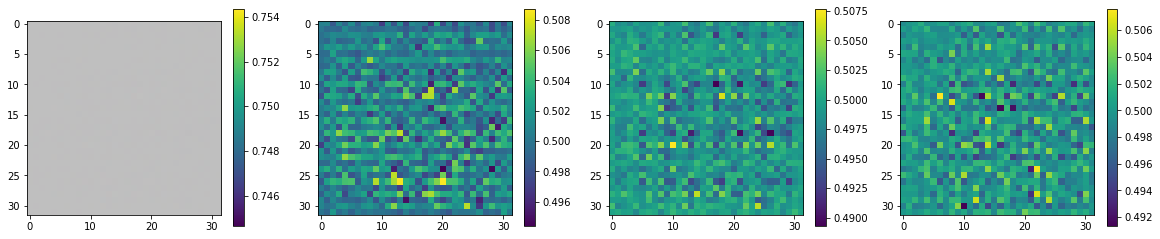

In [11]:
# 이미지 시각화

plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.imshow((generated_image[0, :, :, ] + 1) / 2)
plt.colorbar()
for i in range (3):
    plt.subplot(1, 4, i+2)
    plt.imshow(generated_image[0, :, :, i])
    plt.colorbar()
plt.show()

In [12]:
# 방금 생성된 이미지로 판별자 성능(?) 확인: 거의 가짜 이미지의 확률을 내 밷음 ㅋㅋㅋ
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5054923]], dtype=float32)>

## (5) 각종 loss 함수 설정

In [13]:
# Loss function

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
# generator loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
# discriminator loss

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
#discriminator_accuracy

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## (6) 각종 훈련 관련 함수 설정

In [17]:
# train step 함수 정의

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [18]:
# 일정 학습 당 샘플 생성 함수

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    predictions = (predictions + 1) / 2.0
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        #plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig('{}/aiffel/workplace/EX10_New_Fashion_through_AI/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [19]:
# training_history 생성

rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/workplace/EX10_New_Fashion_through_AI/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [20]:
# Optimizer (옵티마이저는 그래도 좀 세팅좀 해줌)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5)

In [21]:
# 체크 포인트 만들기
checkpoint_dir = os.getenv('HOME')+'/aiffel/workplace/EX10_New_Fashion_through_AI/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
# train 함수 정의

def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [23]:
# 샘플 생성

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [24]:
# 학습 횟수 및 저장간격 설정
save_every = 10
EPOCHS = 200

# (훈련결과1) '생성자-기본1모델 +' 판별자-기본1'모델

- 생성자: Conv2DTranspose()를 사용해서 비선형 항목을 모두 제거한 기본적인 모델 (모델 )
- 판별자: 완전하게 기본모델을 만들기 위해서 비선형성을 주는 항목들을 모조리 제거했다.  
- 그 결과 200epoch를 돌렸지만 생성자가 만들어 내는 이미지는 변하지 않는 결과를 보여주고 있다.

- face accuracy의 경우 1에서 머물며 전혀 판별자를 속이지 못하고 있는 모습을 보이고 있다.
- real accuracy 또한 전혀 상승하지 못하는 상황을 볼 수 있다.

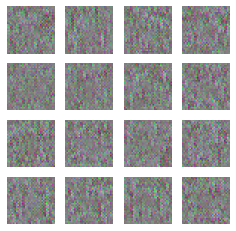

Time for training : 1951 sec


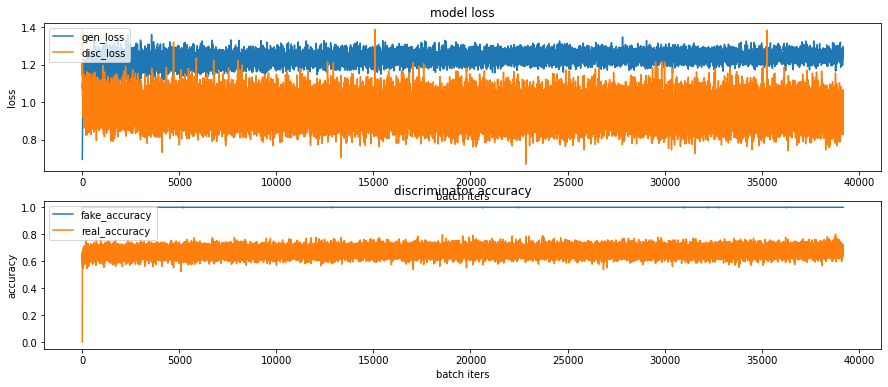

CPU times: user 34min 53s, sys: 4min 21s, total: 39min 14s
Wall time: 32min 34s


In [439]:
%%time
train(train_dataset, EPOCHS, save_every)

### (실험결과1-1) '생성자-기본1' 모델을 적용하여 생성된 노이즈 이미지

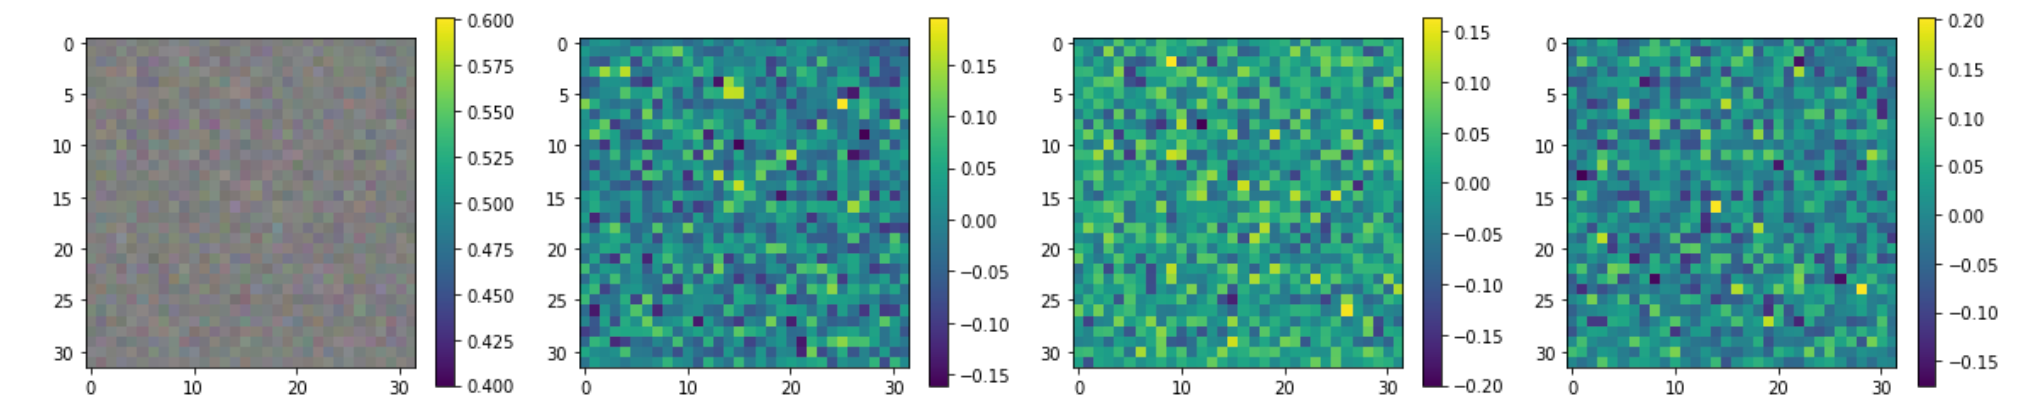

### (실험결과 1-2) '생성자-기본1'모델과 '판별자-기본1'모델을 사용해서 훈련된 이미지
- 픽셀단위로 미세하게 변화하는 것만이 보이며 큰틀에서 변화가 일어나고 있지는 못하다.

![no_img](./ex10img/basic_model1.gif)

# (훈련결과2) '생성자-기본2'모델 +' 판별자-기본1'모델

- '생성자-기본2'모델: UpSampling2D()를 사용해서 비선형 항목을 모두 제거한 기본적인 모델
- '판별자-기본1'모델: 완전하게 기본모델을 만들기 위해서 비선형성을 주는 항목들을 모조리 제거했다. (basic_model1)  
- epoch: 100
- generator_optimizer: adam, learning_rate=0.0003, beta_1=0.5
- discriminator_optimizer: adam, learning_rate=0.0003, beta_1=0.5


- (훈련결과1)과 같이 생성자가 만들어 내는 이미지가 거의 변하지 않는 결과를 보여주고 있다.
- face accuracy의 경우 역시 1에서 머물며 전혀 판별자를 속이지 못하고 있는 모습을 보이고 있다.
- real accuracy 또한 전혀 상승하지 못하는 상황을 볼 수 있다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

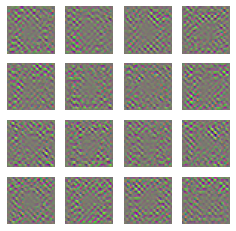

Time for training : 1187 sec


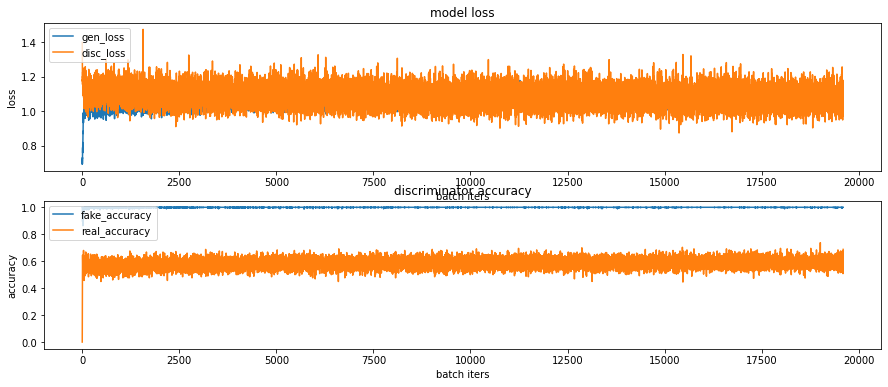

CPU times: user 21min 7s, sys: 2min 20s, total: 23min 28s
Wall time: 19min 48s


In [575]:
%%time
train(train_dataset, EPOCHS, save_every)

### (실험결과2-1) '생성자-기본2'모델을 적용하여 생성된 노이즈 이미지

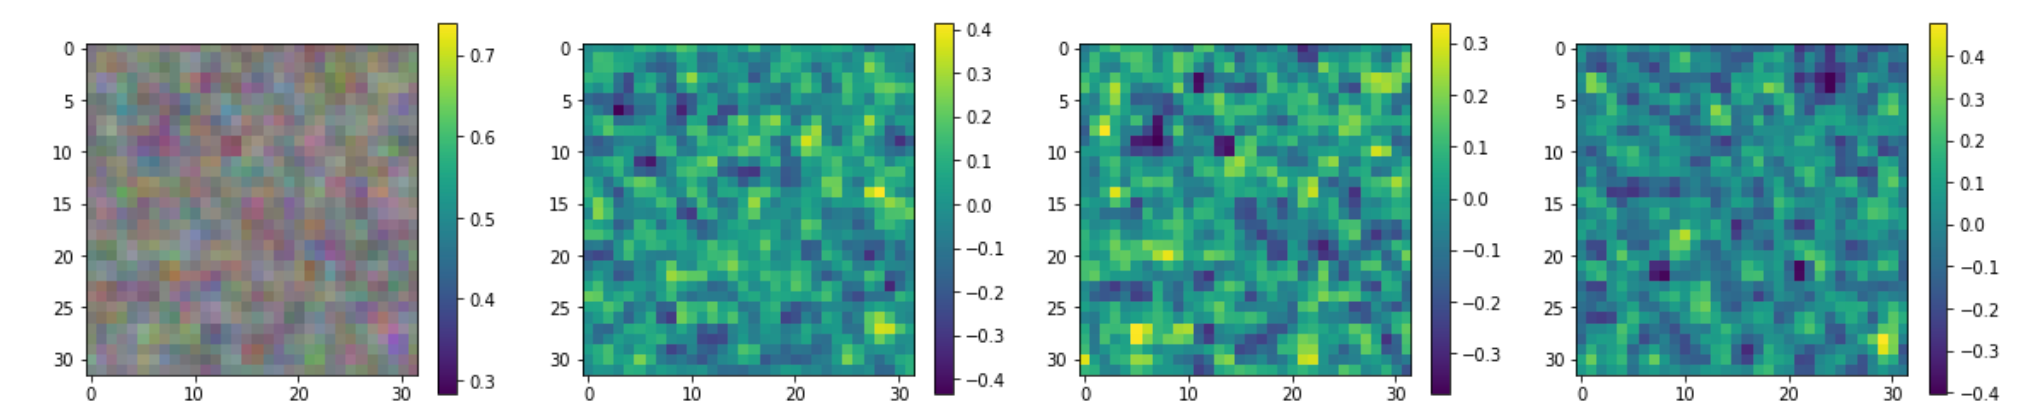

### (실험결과 2-2) '생성자-기본2'모델과 '판별자-기본1'모델을 사용해서 훈련된 이미지
- 픽셀단위로 미세하게 변화하는 것만이 보이며 큰틀에서 변화가 일어나고 있지는 못하다.

![no_img](./ex10img/basic_model1-2.gif)

# (훈련결과3) '생성자-기본2'모델 +' 판별자-수정1'모델

- '생성자-기본2' 모델: Conv2DTranspose()를 사용해서 비선형 항목을 모두 제거한 기본적인 모델
- '판별자-수정1' 모델: 각 Conv2D 레이어에 LeakyReLU() 활성화 함수를 추가 하여 비선형성을 부가한 모델이다. 
- epoch: 100
- generator_optimizer: adam, learning_rate=0.0003, beta_1=0.5
- discriminator_optimizer: adam, learning_rate=0.0003, beta_1=0.5


- 활성화 함수가 없었던 기본 판별자 모델과 달리 훈련을 시작하자마자 이미지가 변하는 것을 확인 할 수 있다.
- 생성자 보다는 판별자가 이미지의 변화에 더 많이 기여 하는 것으로 판단된다. 


- 그래프를 보면 판별자가 매우 강력한 형태를 보이고 있다. 
- 판별자의 로스는 거의 0으로 수렴하고 있으며  생성자의 로스는 점점 증가 하고 있다. 
- 판별자의 accuracy는 점점 증가하여 1로 수렵하는 형태를 보이고 있으며 생성자는 판별자에게 눌려 거의 판별자를 속이지 못하고 있다.


- 판별자가 너무 강력하기 때문에 다음 실험에서는 생성자에게 비선형성을 부가하여 실험을 진행하도록 하겠다.

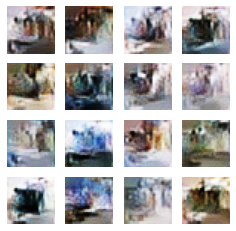

Time for training : 970 sec


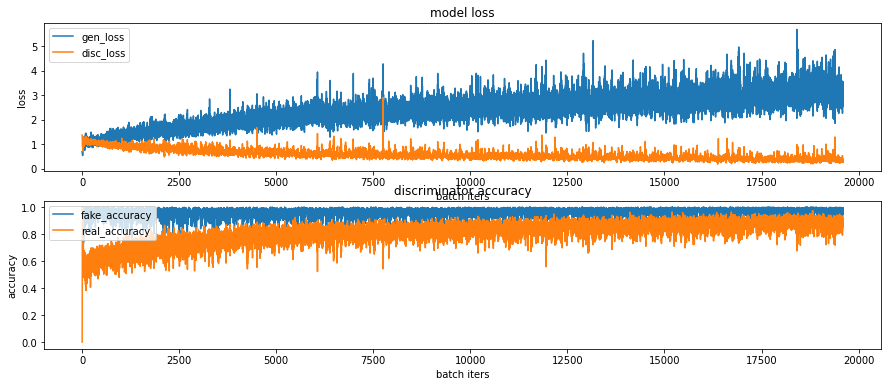

CPU times: user 17min 25s, sys: 2min 11s, total: 19min 36s
Wall time: 16min 11s


In [602]:
%%time
train(train_dataset, EPOCHS, save_every)

### (실험결과3-1) '생성자-기본2'모델을 적용하여 생성된 노이즈 이미지

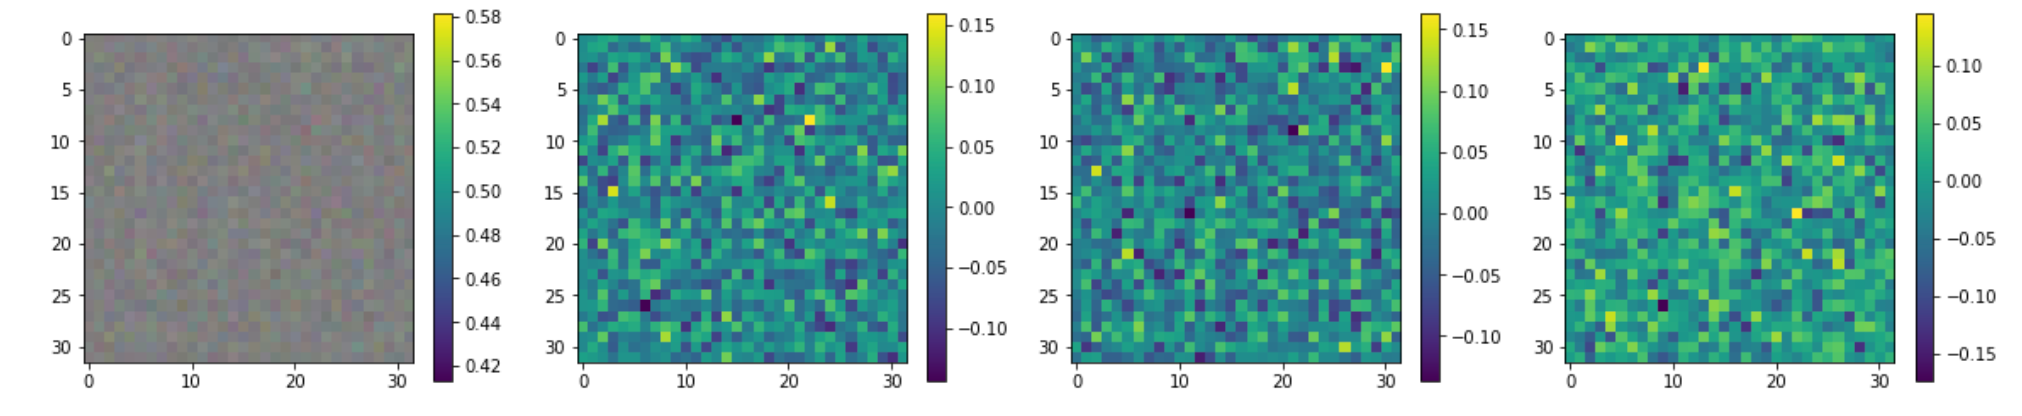

### (실험결과 3-2) '생성자-기본2'모델과 '판별자-수정1'모델을 사용해서 훈련된 이미지


![no_img](./ex10img/basic_model2-2.gif)

# (훈련결과4) '생성자-수정1'모델 +' 판별자-수정1'모델

- '생성자-수정1' 모델: Conv2DTranspose()를 사용한 '생성자-기본1모델'에 Conv2DTranspose()레이어와 활성화 함수를 추가한 모델
- '판별자-수정1' 모델: '판별자-기본1'모델에 LeakyReLU() 활성화 함수를 추가 하여 비선형성을 부가한 모델
- epoch: 200
- generator_optimizer: adam, learning_rate=0.0003, beta_1=0.5
- discriminator_optimizer: adam, learning_rate=0.0003, beta_1=0.5


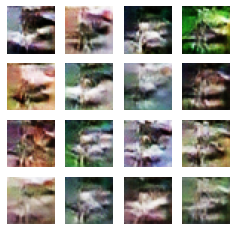

Time for training : 2529 sec


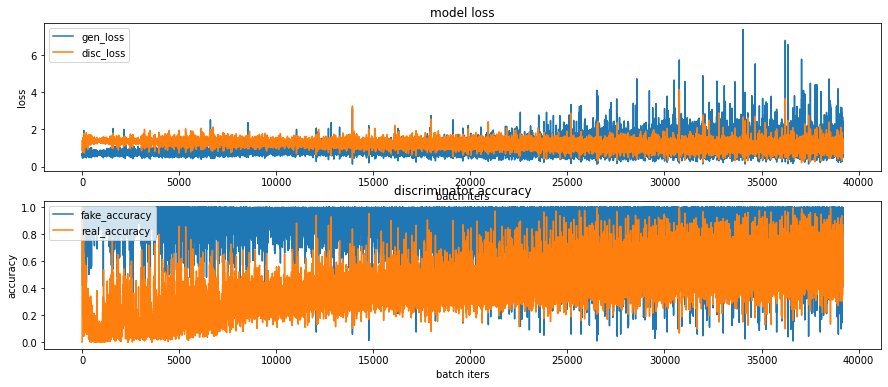

CPU times: user 46min 11s, sys: 5min 10s, total: 51min 21s
Wall time: 42min 11s


In [37]:
%%time
train(train_dataset, EPOCHS, save_every)

### (실험결과4-1) '생성자-수정1'모델을 적용하여 생성된 노이즈 이미지

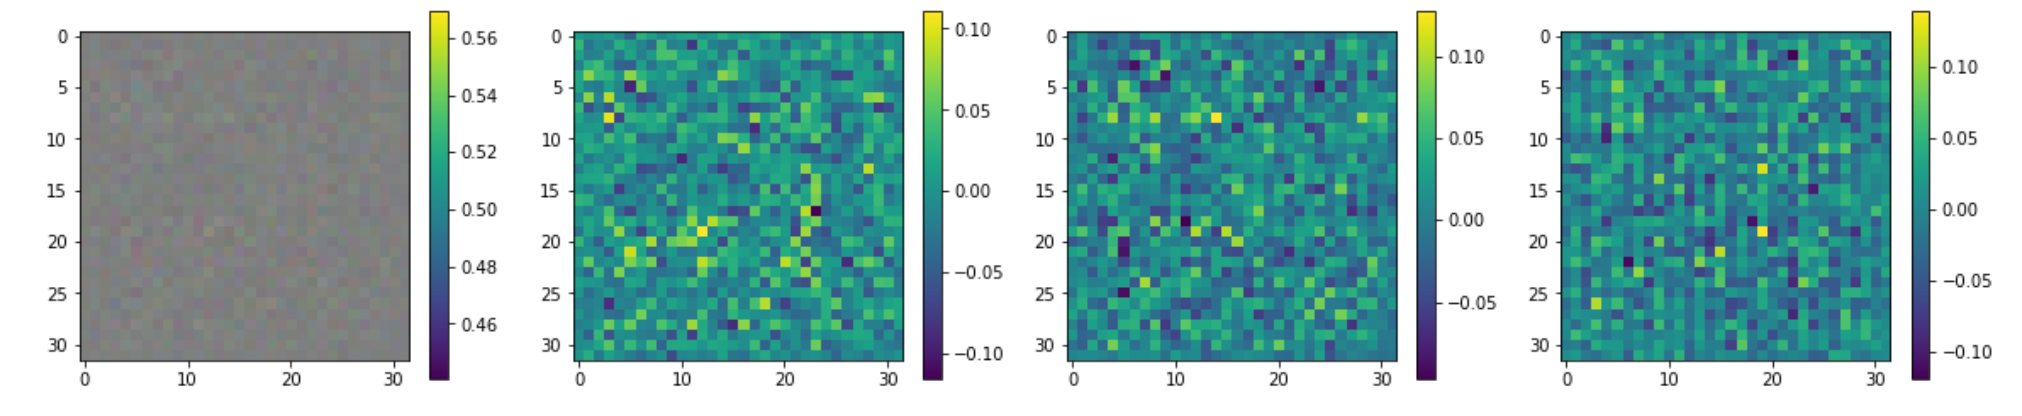

### (실험결과4-1) 훈련을 마친 모델을 적용한 이미지

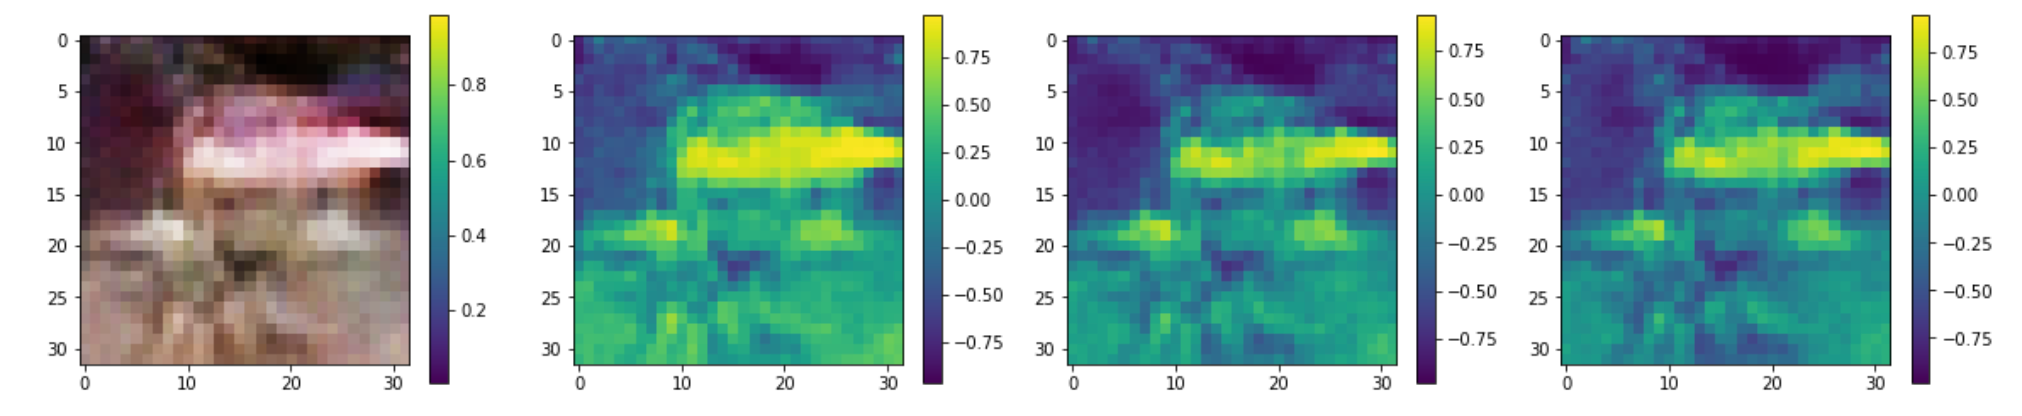

![no_img](./ex10img/train4.gif)

# (훈련결과5) '생성자-수정2'모델 +' 판별자-수정2'모델

수정필요

- '생성자-수정2' 모델: Conv2DTranspose()를 사용한 '생성자-기본1모델'에 Conv2DTranspose()레이어와 활성화 함수를 추가한 모델
- '판별자-수정2' 모델: '판별자-기본1'모델에 LeakyReLU() 활성화 함수와 Dropout을 추가한 모델
- epoch: 200
- generator_optimizer: adam, learning_rate=0.0003, beta_1=0.5
- discriminator_optimizer: adam, learning_rate=0.0003, beta_1=0.5

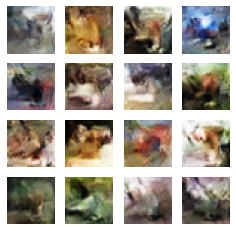

Time for training : 2715 sec


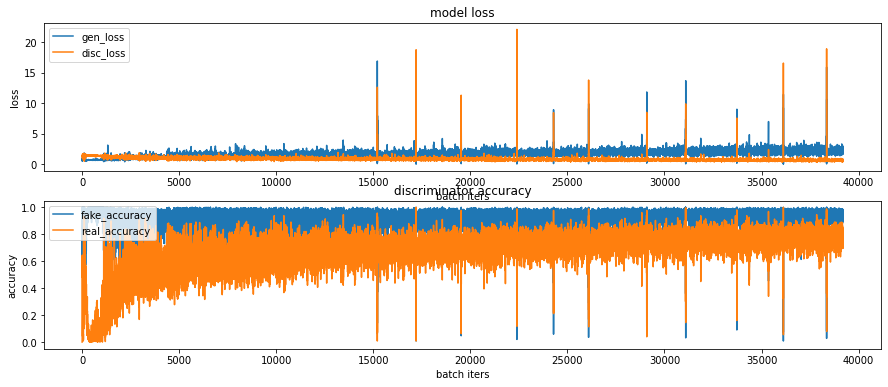

CPU times: user 47min 9s, sys: 4min 19s, total: 51min 28s
Wall time: 45min 17s


In [83]:
%%time
train(train_dataset, EPOCHS, save_every)

### (실험결과5-1) '생성자-수정2'모델을 적용하여 생성된 노이즈 이미지

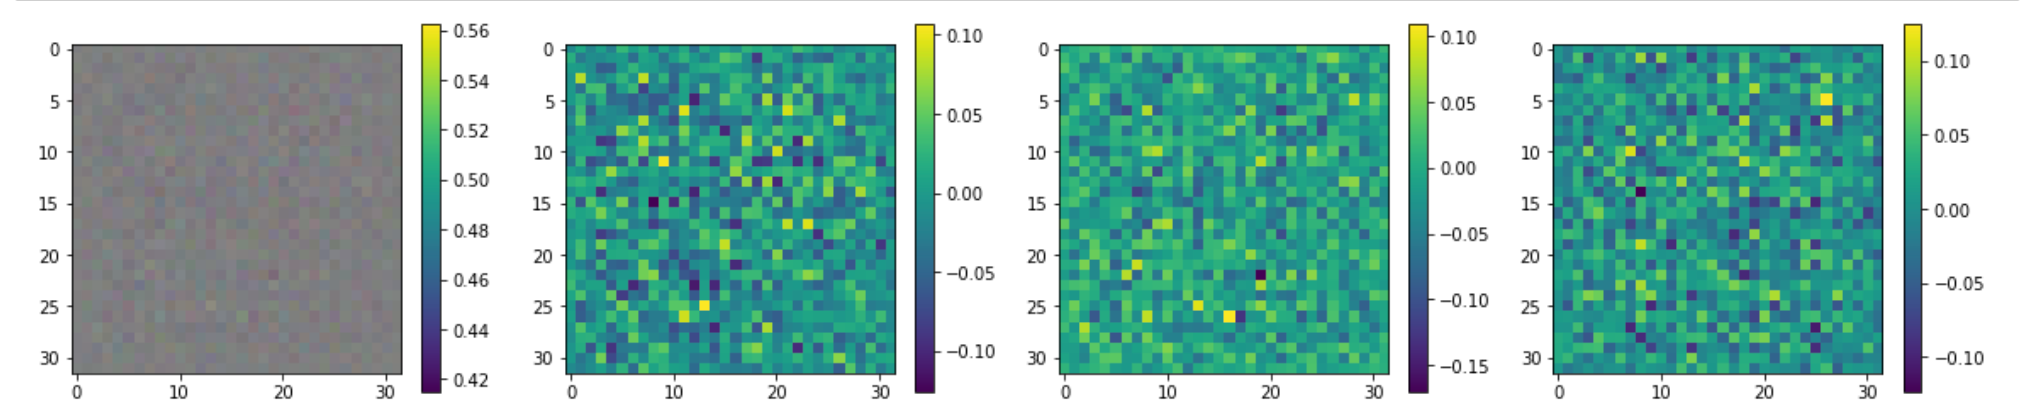

### (실험결과5-1) 훈련을 마친 모델을 적용한 이미지

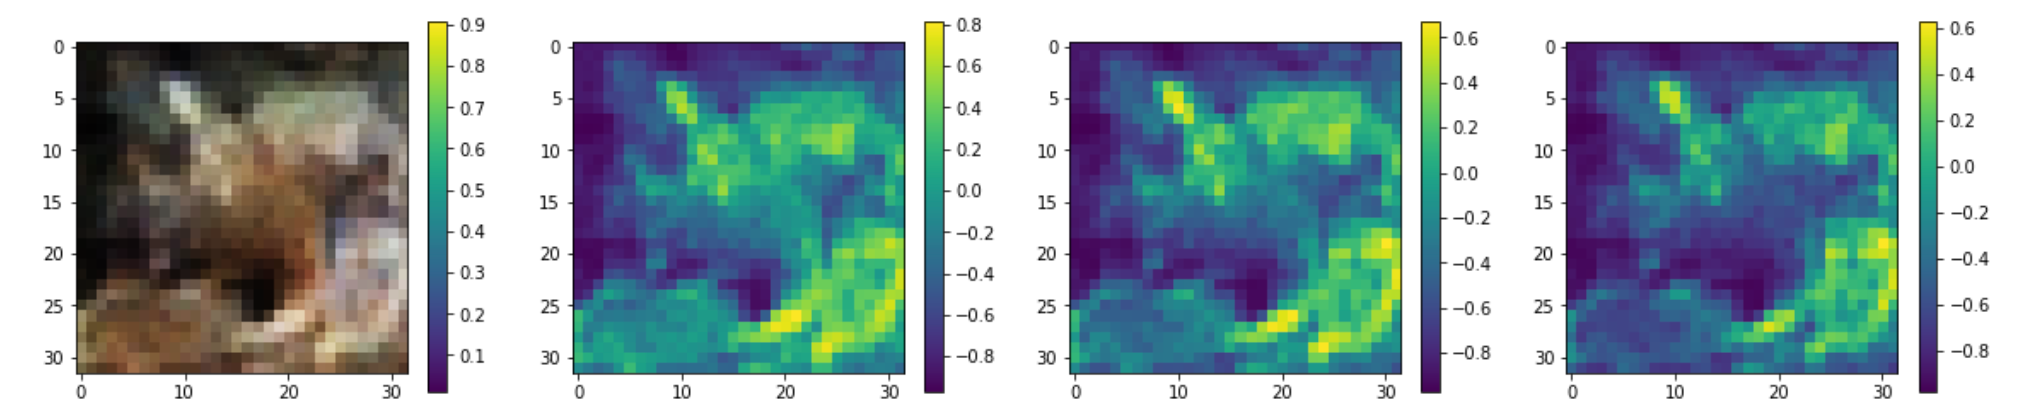

![no_img](./ex10img/train5.gif)

# (훈련결과6) '생성자-수정3'모델 +' 판별자-수정3'모델

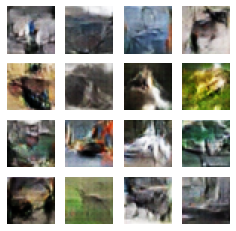

Time for training : 2751 sec


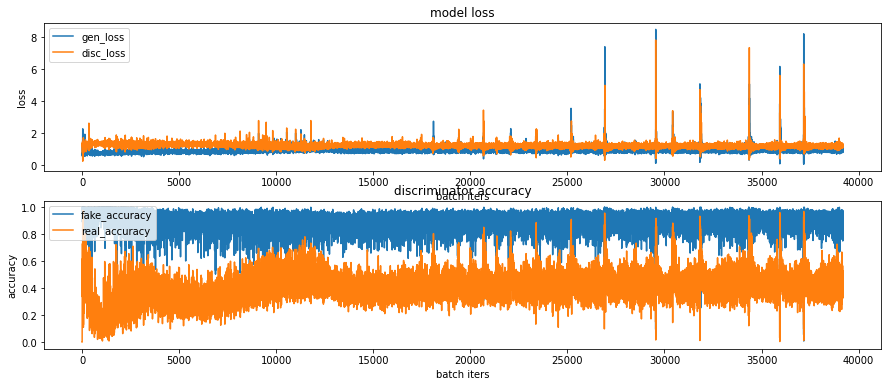

CPU times: user 49min 13s, sys: 5min 5s, total: 54min 18s
Wall time: 45min 54s


In [117]:
%%time
train(train_dataset, EPOCHS, save_every)

### (실험결과6-1) '생성자-수정3'모델을 적용하여 생성된 노이즈 이미지

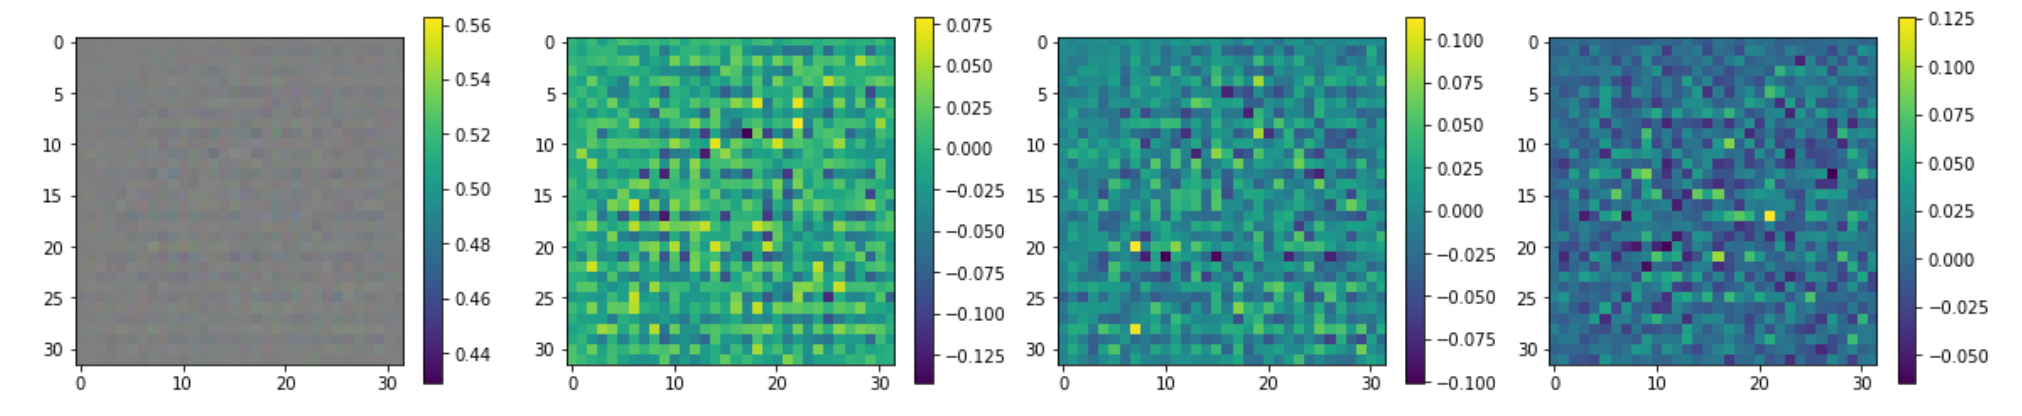

### (실험결과6-2) 훈련을 마친 모델을 적용한 이미지

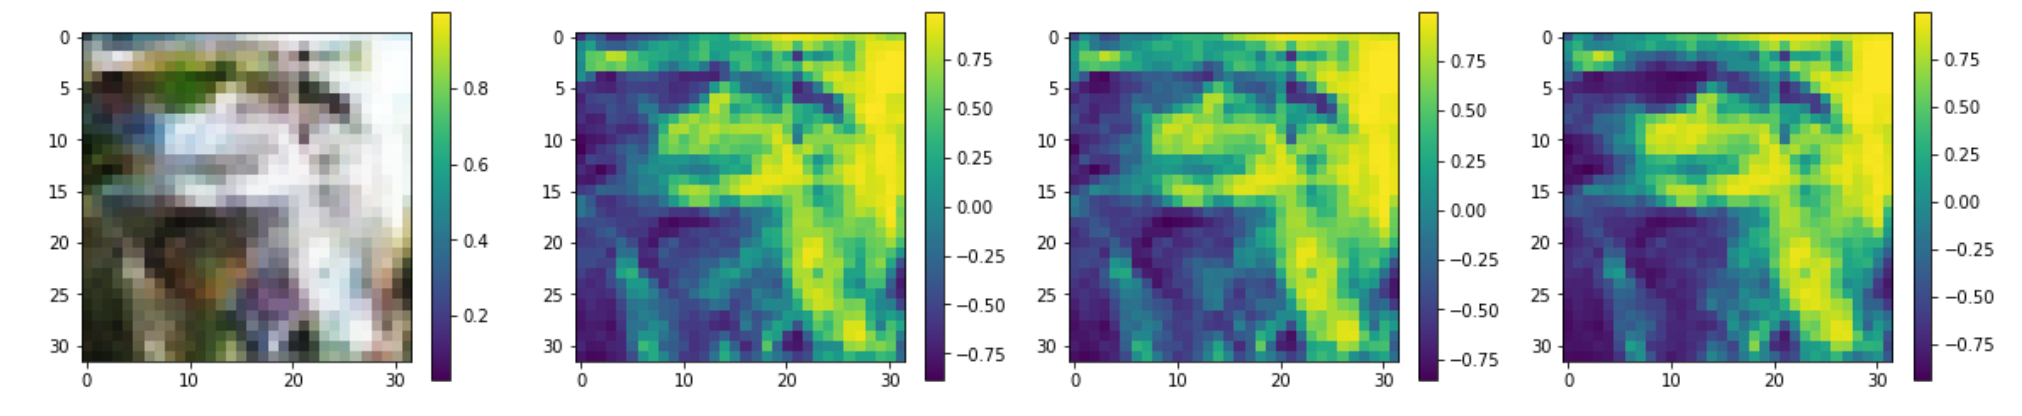

![no_img](./ex10img/train6.gif)

# (훈련결과7) '생성자-수정4'모델 +' 판별자-수정4'모델

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
시간관계상 훈련 7은 마무리 하지 못하고 제출해하는 상황이다. 
안타깝지만 어쩔 수 없다.

## 회고

GAN은 내가 가장 관심 있는 분야 중의 하나였다. 해서 다른 익스플로레이션 보다 조금더 공을 들여서 하려고 생각 했었다.
하지만 생각보다 고려해야 할것들이 많았고 어려웠다. 당연한 결과 였다고 생각한다. 

하고 싶었던 것들은 많았지만 그 많을 것을 짧은 시간동안 할 수 없다는 것은 학습을 시켜보고 알게 되었다. 
학습시간이 어마어마 하게 걸린다. 

그래서 결정한 것이 여러가지를 테스트 해보는 것 보다.
그동안 배웠던 여러가지 기법들 기능들이 GAN의 결과에 어떻게 영향을 미치는지 제대로 확인해 보기로 하였다. 

이를 위해서 가장 첫번쨰로 실험한 것이 아무것도 없는 기본 모델을 만드는 일이었다. 
오직 Conv2DTranspose() 함수만 남겨 놓고 모든 것들을 다 지워버렸다. 
활성화 함수도 없앴고 배치노말라이제이션도 없앴다. 히든레이어도 거의 다 없애고 정말 최소로 필요하다고 생각된 것들만 남겨 놓았다. 

거기서 부터 실험을 시작했다. 
비선형성이 사라져 버린 레이어들을 사용해서 학습을 하였고 

하나씩 추가 할때 마다 변경되는 GAN의 특성들을 관찰하는 식으로 진행하였다. 
완벽하게는 아니지만 DCGAN의 원리에 대해서 어느정도 파악 할 수 있었던 과정이었다. 
이론적으로도 더 많이 보강해서 GAN을 주종목을오 삼아도 문제 없을 정도로 만들고 싶다.

In [ ]:
# Save model`s weights

model.save_weights(str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/basic_model_1.h5'))

In [118]:
# generated_samples gif 만들기

anim_file = os.getenv('HOME')+'/aiffel/workplace/EX10_New_Fashion_through_AI/dcgan_newimage/cifar10/train6.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/workplace/EX10_New_Fashion_through_AI/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)